In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

import multiprocessing
if __name__=='__main__':
    multiprocessing.set_start_method("fork")

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy 
no cupy
No CuPy or GPU PhenomHM module.
has BBHx waveform


## Response 

## F-stat 

## Data settings 

In [4]:
t_start = 150. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 20. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(10801,)

In [5]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_CPU = xp.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((10666,), (10666,))

## Set response model 

In [6]:
# the path of Taiji orbit 
orbit_CPU = Orbit(OrbitDir="/Users/taijidatacenter/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") 

# initialize  waveform generator 
WFG_CPU = WaveformGenerator(
    mode="primary", 
)

# initialize response generator 
FDTDI_CPU = FDTDIResponseGenerator(
    orbit_class=orbit_CPU, 
    waveform_generator=WFG_CPU, 
)

# response settings 
response_kwargs_CPU = dict(
    modes=[(2, 2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    tc_at_constellation=True, # whether tc is the coalescence time at constellation center (True) or SSB (False)
    TDIGeneration='2nd',
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
)

## Source parameter priors 

In [7]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [(t_start + 0.75 * Tobs) / DAY, t_end / DAY - 1.] # ensure the inclusion of long enough GW waveform 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.50000000e+00,  6.50000000e+00],
       [ 1.00000000e-01,  1.00000000e+00],
       [-9.00000000e-01,  9.00000000e-01],
       [-9.00000000e-01,  9.00000000e-01],
       [ 1.53750000e+02,  1.54000000e+02],
       [ 0.00000000e+00,  6.28318531e+00],
       [-1.00000000e+00,  1.00000000e+00]])

## Noise model 

In [8]:
arm_time = np.mean(intrinsic_param_priors[4]) * DAY 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_CPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

((3, 10666), (10666, 3, 3))

## Data simulation 

In [19]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 1539043.4911945574
mass_ratio : 0.3005982648095507
spin_1z : -0.44659199480912615
spin_2z : -0.5121944463557722
coalescence_time : 153.98306870012513
coalescence_phase : 1.619414288765191
luminosity_distance : 70075.24956007842
inclination : 1.2947201239660169
longitude : 4.283065654067103
latitude : 0.13366858504708365
psi : 0.10160522058857452
optimal SNR: 535.1793379893287


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

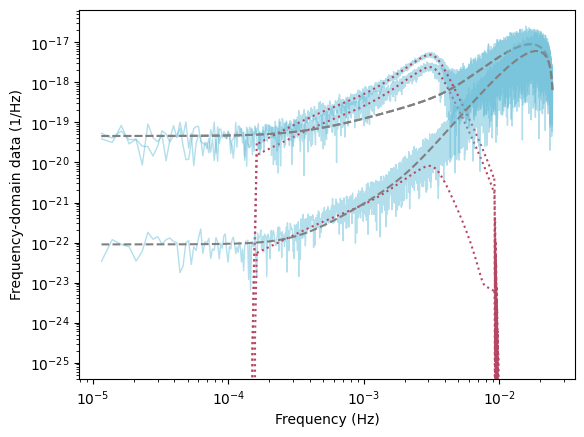

In [20]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel]), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel]), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## MLE with  $\mathcal{F}$-stat 

In [21]:
Fstat = Fstatistics(
    response_generator=FDTDI_CPU, 
    frequency=data_frequencies_CPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_CPU, 
    use_gpu=False
)

number of freuqncies: 10666
min and max frequencies: 1.1574074074074073e-05 0.024699074074074075
response kwargs: {'modes': [(2, 2)], 'tmin': 150.0, 'tmax': 155.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


### test waveform and parameter recovery

In [22]:
int_params = dict()
for key in Fstatistics.intrinsic_parameter_names:
    int_params[key] = mbhb_parameters[key]
int_params

{'chirp_mass': 1539043.4911945574,
 'mass_ratio': 0.3005982648095507,
 'spin_1z': -0.44659199480912615,
 'spin_2z': -0.5121944463557722,
 'coalescence_time': 153.98306870012513,
 'longitude': 4.283065654067103,
 'latitude': 0.13366858504708365}

In [23]:
rec_a = Fstat.calculate_Fstat(
    intrinsic_parameters=int_params, 
    return_a=True, 
)
# print(rec_a.shape)

rec_ext_params = Fstat.a_to_extrinsic(rec_a)

rec_params = dict(int_params, **rec_ext_params)

print("parameter name | true value | difference")
for k, v in rec_ext_params.items():
    print(k, ":", mbhb_parameters[k], v-mbhb_parameters[k])

parameter name | true value | difference
luminosity_distance : 70075.24956007842 -146.3492005970911
inclination : 1.2947201239660169 0.0007262853242830936
psi : 0.10160522058857452 0.0006531236540452123
coalescence_phase : 1.619414288765191 -1.5697427730854268


In [24]:
rec_wave1 = FDTDI_CPU.Response(
    rec_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

rec_wave2 = Fstat.calculate_Fstat(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)

rec_wave1.shape, rec_wave2.shape 

((3, 10666), (3, 10666))

(1e-25, 2.241671483619817e-17)

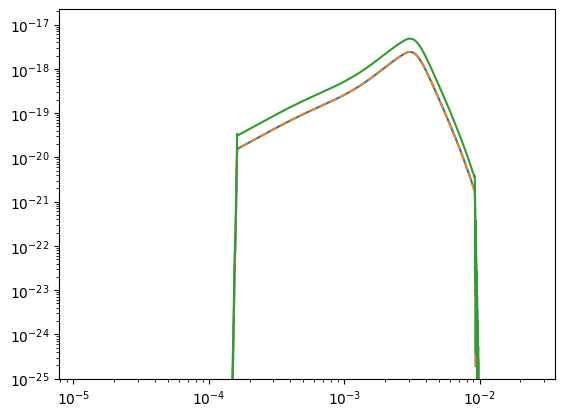

In [25]:
plt.loglog(data_frequencies_CPU, np.abs(rec_wave1[0]))
plt.loglog(data_frequencies_CPU, np.abs(rec_wave2[0]), linestyle="--")
plt.loglog(data_frequencies_CPU, np.abs(rec_wave1[0] - rec_wave2[0]))
plt.ylim(1e-25,)

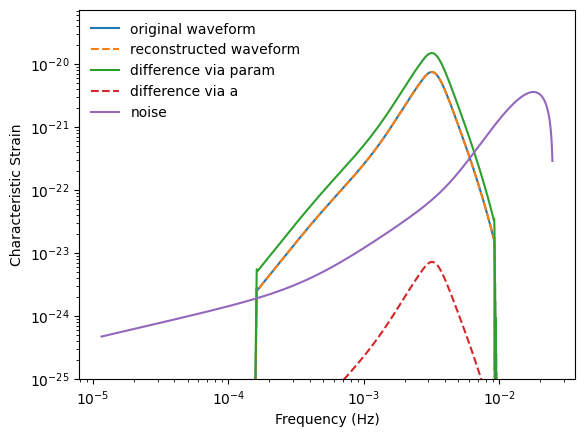

In [26]:
plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0]) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0] - wf_channels[0]) * data_frequencies, label="difference via param")
plt.loglog(data_frequencies, np.abs(rec_wave2[0] - wf_channels[0]) * data_frequencies, label="difference via a", linestyle="--")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

### optimization from prior 

In [27]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams), normalized to (0, 1)
    """
    int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params) # (Nparams) -> dictionary
    return -Fstat.calculate_Fstat(intrinsic_parameters=params_in) # float

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    # tol=1e-7,
    # atol=1e-9,
    tol=1e-6,
    atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=True,
    polish=False,
    # vectorized=True,
    workers=-1, 
)

/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= -127887.43655016558
differential_evolution step 2: f(x)= -127887.43655016558
differential_evolution step 3: f(x)= -127887.43655016558
differential_evolution step 4: f(x)= -127887.43655016558
differential_evolution step 5: f(x)= -140306.5517864038
differential_evolution step 6: f(x)= -140306.5517864038
differential_evolution step 7: f(x)= -140306.5517864038
differential_evolution step 8: f(x)= -141605.4430333503
differential_evolution step 9: f(x)= -141605.4430333503
differential_evolution step 10: f(x)= -141605.4430333503
differential_evolution step 11: f(x)= -141605.4430333503
differential_evolution step 12: f(x)= -141605.4430333503
differential_evolution step 13: f(x)= -141693.01624937638
differential_evolution step 14: f(x)= -141696.19658344728
differential_evolution step 15: f(x)= -141696.19658344728
differential_evolution step 16: f(x)= -141696.19658344728
differential_evolution step 17: f(x)= -141975.02505373725
differential_evolution step 18:

### reconstruct parameters and waveforms 

In [ ]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

searched_a = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

print("parameter name | true value | difference")
for k, v in searched_params.items():
    print(k, mbhb_parameters[k], np.abs(v-mbhb_parameters[k]))

In [ ]:
searched_wf1 = FDTDI_CPU.Response(
    searched_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

searched_wf2 = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
)

plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="injected waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0]) * data_frequencies, linestyle="--", label="searched waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0] - wf_channels[0]) * data_frequencies, linestyle="-", label="difference via param")
plt.loglog(data_frequencies, np.abs(searched_wf2[0] - wf_channels[0]) * data_frequencies, linestyle="-", label="difference via a")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25, )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strain")
plt.legend(loc="upper left")

## Fisher analysis 

In [ ]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_CPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_CPU, 
    )
    return res

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.01,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

In [ ]:
print("parameter name | difference | FIM bound | ratio")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), FIM.param_errors[k], np.abs(v-mbhb_parameters[k]) / FIM.param_errors[k])

In [ ]:
# test_dtc = np.linspace(-1e-2, 1e-2, 1000) 
# test_dsnr = np.zeros_like(test_dtc)

# for i in range(len(test_dtc)):
#     test_dsnr[i] = FrequencyDomainCovarianceSNR(data_channels=(wf_channels-searched_wf*xp.exp(1.j*TWOPI*data_frequencies_CPU*test_dtc[i]*DAY)), inv_cov=InvCovMat)

In [ ]:
# plt.plot(test_dtc, test_dsnr)
# plt.vlines(mbhb_parameters["coalescence_time"] - searched_params["coalescence_time"], 0, 10000)

## Test across population 

In [ ]:
truths_list = [] 
searched_list = [] 
FIM_bound_list = [] 
snr_list = [] 

for i in tqdm(range(100)):

    # generate source parameter and clean signal 
    mbhb_parameters = {
        'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
        'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
        'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
        'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
        'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
        'coalescence_phase': np.random.uniform(0, TWOPI),
        'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
        'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
        'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
        'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
        'psi': np.random.uniform(0, PI) # [rad]
        }
    wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

    # generate frequency-domain noises 
    Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

    # combine signal and noise 
    data_channels = wf_channels + noise_channels 

    opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)
    snr_list.append(opt_SNR)

    # print("source parameters:")
    # for k, v in mbhb_parameters.items():
    #     print(k, ":", v)
    # print("optimal SNR:", opt_SNR)

    Fstat = Fstatistics(
        response_generator=FDTDI_CPU, 
        frequency=data_frequencies_CPU, 
        data=data_channels, 
        invserse_covariance_matrix=InvCovMat, 
        response_parameters=response_kwargs_CPU, 
        use_gpu=False
    )

    # from scipy.optimize import differential_evolution

    # n_dim_int = len(Fstatistics.intrinsic_parameter_names)
    # print("number of parameters to be optimized:", n_dim_int)

    def cost_function(norm_int_params):
        """   
            norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
        """
        int_params = norm_int_params.transpose() * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nevent, Nparams)
        params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
        return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

    n_dim_int = 7 
    lower_bounds = np.zeros(n_dim_int) 
    upper_bounds = np.ones(n_dim_int) 
    bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

    DE_result = differential_evolution(
        func=cost_function,
        bounds=bounds,
        x0=None,
        strategy='best1exp',
        # strategy='rand1bin',
        maxiter=5000,
        popsize=10*n_dim_int,
        # popsize=6*n_dim_int, 
        tol=1e-7,
        atol=1e-9,
        # tol=1e-6,
        # atol=1e-8,
        mutation=(0.4, 0.95),
        recombination=0.7,
        disp=False,
        polish=False,
        vectorized=True,
    )

    searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

    searched_a = Fstat.calculate_Fstat_vectorized(
        intrinsic_parameters=searched_int_params, 
        return_a=True, 
    ) # (1, 4)
    searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

    searched_params = dict(searched_int_params, **searched_ext_params)

    def fisher_waveform_wrapper(param_dict, frequencies):
        res = FDTDI_CPU.Response(
            parameters=param_dict, 
            freqs=xp.array(frequencies),  
            **response_kwargs_CPU, 
        )
        return res

    # set initial steps 
    analyze_param_step_dict = {
        'chirp_mass': 10.,
        'mass_ratio': 0.01,
        'spin_1z': 0.01,
        'spin_2z': 0.01,
        'coalescence_time': 0.001,
        'coalescence_phase': 0.01,
        'luminosity_distance': 10.,
        'inclination': 0.01,
        'longitude': 0.01,
        'latitude': 0.01,
        'psi': 0.01
        }
    for k, v in analyze_param_step_dict.items():
        analyze_param_step_dict[k] = -v 

    FIM = MultiChannelFisher(
        waveform_generator=fisher_waveform_wrapper, 
        param_dict=mbhb_parameters, 
        # param_dict=searched_params, 
        analyze_param_step_dict=analyze_param_step_dict, 
        frequency=data_frequencies, 
        inverse_covariance=InvCovMat, 
        verbose=0,
    )

    FIM.auto_test_step()
    FIM.calculate_Fisher()
    FIM.calculate_errors() 

    truths_list.append(mbhb_parameters)
    searched_list.append(searched_params)
    FIM_bound_list.append(FIM.param_errors)

In [ ]:
bins = np.logspace(1.5, 4.5, 30)
plt.hist(snr_list, bins=bins, density=False, facecolor=None, edgecolor=YELLOW, hatch="//", histtype='step', lw=2); 
plt.xlabel("SNR")
plt.ylabel("number of MBHBs in bin")
plt.xscale("log")

In [ ]:
Mc_list = np.array([paramdict["chirp_mass"] for paramdict in truths_list])
q_list = np.array([paramdict["mass_ratio"] for paramdict in truths_list])
s1_list = np.array([paramdict["spin_1z"] for paramdict in truths_list])
s2_list = np.array([paramdict["spin_2z"] for paramdict in truths_list])
tc_list = np.array([paramdict["coalescence_time"] for paramdict in truths_list])
dl_list = np.array([paramdict["luminosity_distance"] for paramdict in truths_list])
inc_list = np.array([paramdict["inclination"] for paramdict in truths_list])
lon_list = np.array([paramdict["longitude"] for paramdict in truths_list])
lat_list = np.array([paramdict["latitude"] for paramdict in truths_list])

Mc_list1 = np.array([paramdict["chirp_mass"] for paramdict in searched_list])
q_list1 = np.array([paramdict["mass_ratio"] for paramdict in searched_list])
s1_list1 = np.array([paramdict["spin_1z"] for paramdict in searched_list])
s2_list1 = np.array([paramdict["spin_2z"] for paramdict in searched_list])
tc_list1 = np.array([paramdict["coalescence_time"] for paramdict in searched_list])
dl_list1 = np.array([paramdict["luminosity_distance"] for paramdict in searched_list])
inc_list1 = np.array([paramdict["inclination"] for paramdict in searched_list])
lon_list1 = np.array([paramdict["longitude"] for paramdict in searched_list])
lat_list1 = np.array([paramdict["latitude"] for paramdict in searched_list])

Mc_list2 = np.array([paramdict["chirp_mass"] for paramdict in FIM_bound_list])
q_list2 = np.array([paramdict["mass_ratio"] for paramdict in FIM_bound_list])
s1_list2 = np.array([paramdict["spin_1z"] for paramdict in FIM_bound_list])
s2_list2 = np.array([paramdict["spin_2z"] for paramdict in FIM_bound_list])
tc_list2 = np.array([paramdict["coalescence_time"] for paramdict in FIM_bound_list])
dl_list2 = np.array([paramdict["luminosity_distance"] for paramdict in FIM_bound_list])
inc_list2 = np.array([paramdict["inclination"] for paramdict in FIM_bound_list])
lon_list2 = np.array([paramdict["longitude"] for paramdict in FIM_bound_list])
lat_list2 = np.array([paramdict["latitude"] for paramdict in FIM_bound_list])

In [ ]:
bins = np.linspace(-12, 12, 50)
plt.hist((Mc_list1 - Mc_list) / Mc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="chirp mass");
plt.hist((q_list1 - q_list) / q_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="mass ratio");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-12, 12, 50)
plt.hist((s1_list1 - s1_list) / s1_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="spin 1");
plt.hist((s2_list1 - s2_list) / s2_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="spin 2");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((lon_list1 - lon_list) / lon_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="longitude");
plt.hist((lat_list1 - lat_list) / lat_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="latitude");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((dl_list1 - dl_list) / dl_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="luminosity distance");
plt.hist((inc_list1 - inc_list) / inc_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="inclination");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((tc_list1 - tc_list) / tc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="coalescence time");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)